In [1]:
import or_gym
from or_gym.utils import create_env
import ray
from ray.rllib.agents.ppo import PPOTrainer
from ray import tune
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import gridspec

Instructions for updating:
non-resource variables are not supported in the long term


In [2]:
def register_env(env_name, env_config={}):
    env = create_env(env_name)
    tune.register_env(env_name, 
        lambda env_name: env(env_name,
            env_config=env_config))

# Environment and RL Configuration Settings
env_name = 'NetworkManagement-v0'
# env_name = "Knapsack-v0"
env_config = {} # Change environment parameters here
rl_config = dict(
    env=env_name,
    # Use 0 workers for simplicity and to avoid Windows errors
    num_workers=0,
    env_config=env_config,
    
    # A standard, simple configuration for a simple problem
    model=dict(
        fcnet_hiddens=[32, 32], # A small network is sufficient
        fcnet_activation='relu'
    ),
    
    # Use a standard learning rate
    lr=5e-5,
    gamma=0.99, # A standard discount factor
    
    # Use CPU-friendly batch sizes
    train_batch_size=4000,
    sgd_minibatch_size=128,
    num_sgd_iter=10,
    
    # The episode ends after considering all 200 items
    horizon=200, 
    
    framework="torch",
    num_gpus=0, # Force CPU
)
 
# Register environment
register_env(env_name, env_config)

In [3]:
# Initialize Ray and Build Agent
ray.init(ignore_reinit_error=True)
agent = PPOTrainer(env=env_name,
    config=rl_config)
 
results = []
for i in range(300):
    res = agent.train()
    results.append(res)
    print('\rIter: {}\tReward: {:.2f}'.format(
            i+1, res['episode_reward_mean']), end='')
#ray.shutdown()

2025-11-10 21:15:59,160	INFO services.py:1164 -- View the Ray dashboard at http://127.0.0.1:8265
2025-11-10 21:16:01,529	ERROR syncer.py:63 -- Log sync requires rsync to be installed.
2025-11-10 21:16:01,529	INFO trainer.py:616 -- Current log_level is WARN. For more information, set 'log_level': 'INFO' / 'DEBUG' or use the -v and -vv flags.
2025-11-10 21:16:01,546	WARNING util.py:39 -- Install gputil for GPU system monitoring.


Iter: 300	Reward: 672.747

In [5]:
# Save agent weights
checkpoint = agent.save()
print("Agent checkpoint saved at: {}".format(checkpoint))

Agent checkpoint saved at: C:\Users\24608/ray_results\PPO_NetworkManagement-v0_2025-11-10_21-16-01k5703a4k\checkpoint_300\checkpoint-300


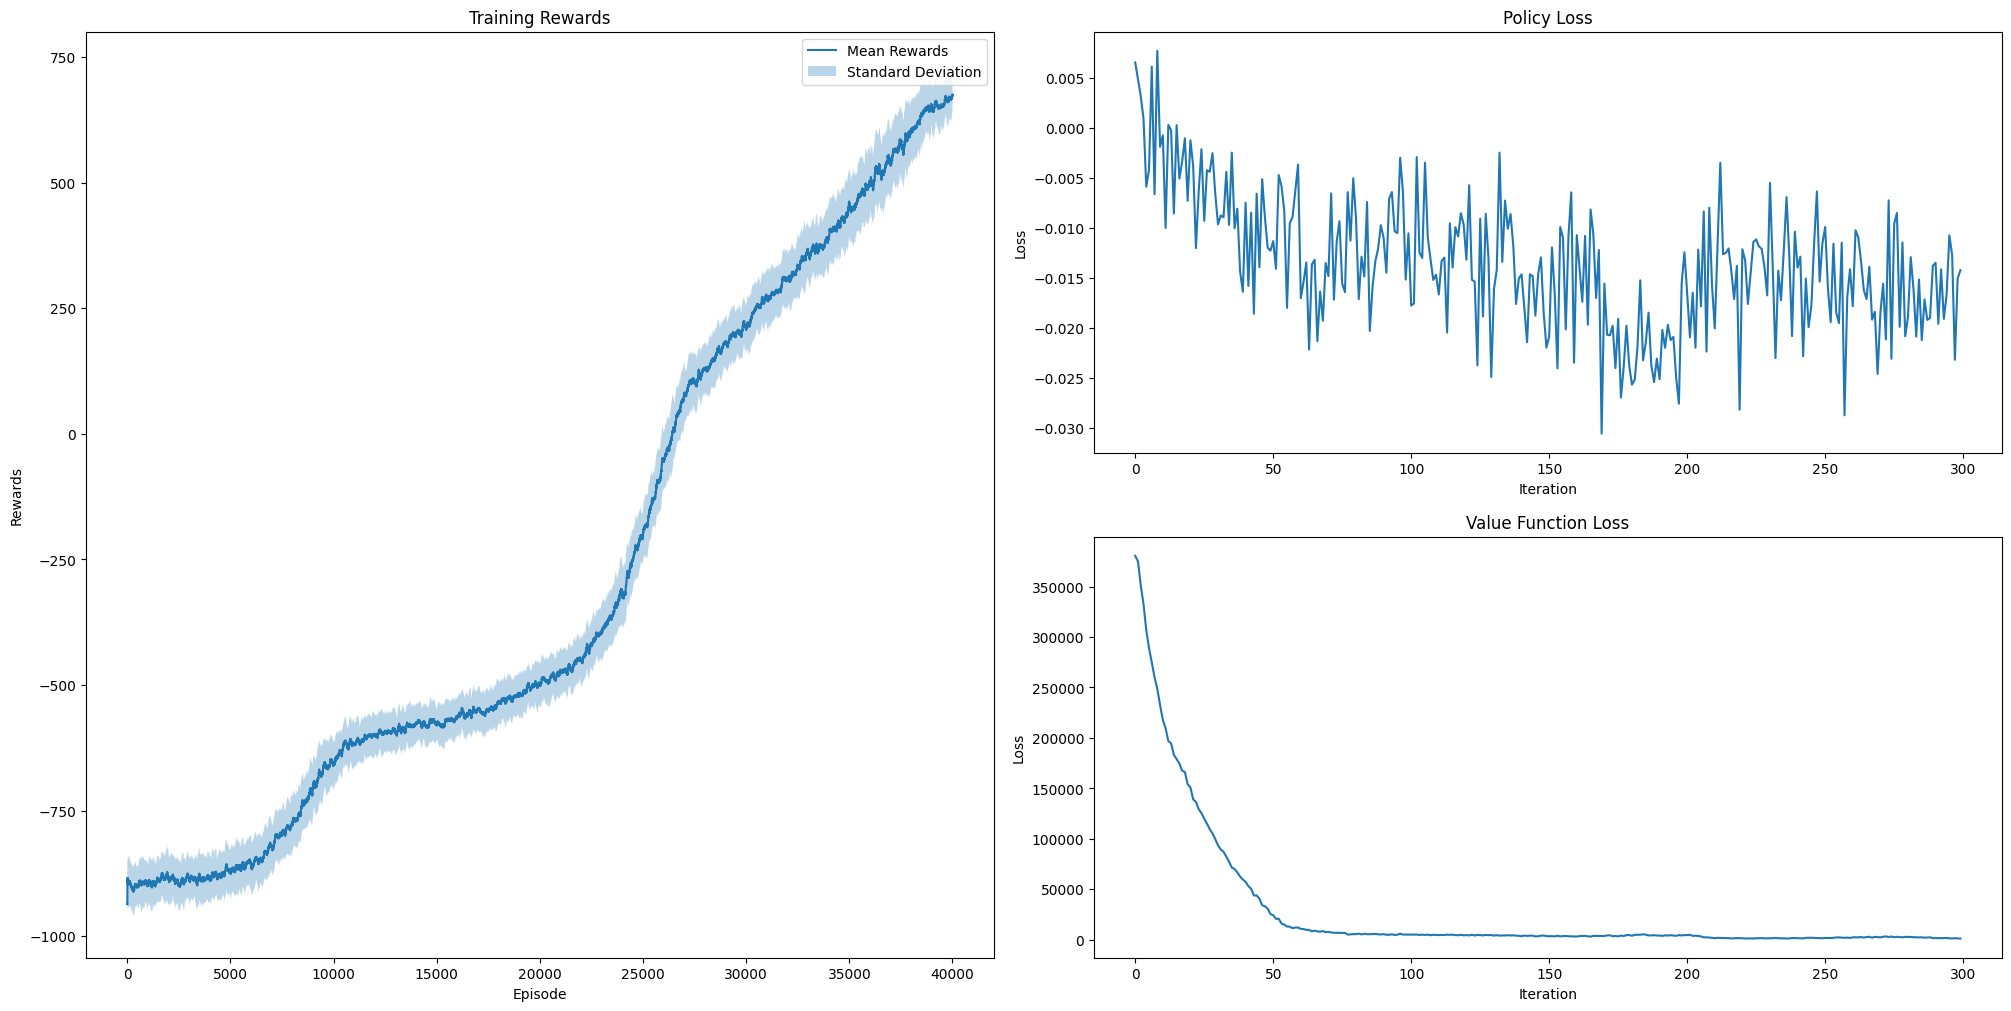

In [4]:
# Unpack values from each iteration
rewards = np.hstack([i['hist_stats']['episode_reward'] 
    for i in results])
pol_loss = [
    i['info']['learner']['default_policy']['policy_loss'] 
    for i in results]
vf_loss = [
    i['info']['learner']['default_policy']['vf_loss'] 
    for i in results]
p = 100
mean_rewards = np.array([np.mean(rewards[i-p:i+1]) 
                if i >= p else np.mean(rewards[:i+1]) 
                for i, _ in enumerate(rewards)])
std_rewards = np.array([np.std(rewards[i-p:i+1])
               if i >= p else np.std(rewards[:i+1])
               for i, _ in enumerate(rewards)])
fig = plt.figure(constrained_layout=True, figsize=(20, 10))
gs = fig.add_gridspec(2, 4)
ax0 = fig.add_subplot(gs[:, :-2])
ax0.fill_between(np.arange(len(mean_rewards)), 
                 mean_rewards - std_rewards, 
                 mean_rewards + std_rewards, 
                 label='Standard Deviation', alpha=0.3)
ax0.plot(mean_rewards, label='Mean Rewards')
ax0.set_ylabel('Rewards')
ax0.set_xlabel('Episode')
ax0.set_title('Training Rewards')
ax0.legend()
ax1 = fig.add_subplot(gs[0, 2:])
ax1.plot(pol_loss)
ax1.set_ylabel('Loss')
ax1.set_xlabel('Iteration')
ax1.set_title('Policy Loss')
ax2 = fig.add_subplot(gs[1, 2:])
ax2.plot(vf_loss)
ax2.set_ylabel('Loss')
ax2.set_xlabel('Iteration')
ax2.set_title('Value Function Loss')
plt.show()

In [ ]:
plt.savefig('temp.png')

<Figure size 640x480 with 0 Axes>